# General Information

## Context:
It is October 2018 and a fashion retailer, “The Company” (C), is entering a major markdown season
and would like to plan ahead.

## Objective:
In order to maximize profit, C would like to have a model to predict the impact on sales of a particular 
markdown on a particular product. The objective of this exercise is to help C make its markdown plans.


## Data: 
The historical data we will consider was recorded in October 2017 in Nordic countries. The weather 
was particularly cold during that period, as customers were reviewing marked down offers for the fall 
collections.
The data set is composed of three weeks; the first week was the one just before the markdown season 
began, with no major discounts applied. For the sake of clarity, we will call the week without 
markdowns for **week 0**, the first week with markdowns for **week 1**, and the second week of 
markdowns for **week 2**.
The two datasets (more detailed explanations in the Appendix below):
- Sales_master.csv, which contains the sales data 
- Product_table.csv, which contains generic information for each variant of each article. NB: An “article” is a product with a particular color/print. A “variant” is a version of an article with a particular size. For instance:
    * Product 512787 is a V-neck sweater
    * Article 512787004 is a red V-neck sweater
    * Variants 512787004003, 512787004004 and 512787004006 are three different sizes of the red V-neck sweater. Notice how the 9 first numbers of the variant ID is the article ID
    

#### Now it is the end of September 2018, and the markdown period for October 2018 starts next week. Using the data you have, build a model to predict demand. Using your model, suggest a plan of action for markdowns for the first week of  markdown October 2018.   


# Questions:
1) What type of trends can you observe per week and per product? What can you tell about the discounts and their impact on sales?
Tip: a reference variable for this study is the uplift, i.e. the factor between the sales during a markdown week and the sales during a week without markdown close in time.

2) Is it possible to predict the uplift for the first week of markdowns with the information you have? What would be the key variables? (please do not take week 2 into account in this question)

3) Suggest a specific plan of action for markdowns in October 2018, based on your observations and models on week 1. 



## Appendix

* Sales_master.csv:
    * Gross_amount: the total sales that were generated with this particular variant not taking discount into account
    * Net_amount: the total sales that were generated with this particular after discount (so it shows what the customers actually paid)
    * Purchases: number of item sold
* Product_table.csv:
    * Index_group_name, department name and product_type_name represent three levels of granularity describing the product (index being the higher-lever one and product_type_name the lowest)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
product = pd.read_csv('product_table.csv')
product['article_FIRST_OF_DIGITS'] = pd.to_numeric(product['article'].astype(str).str[:6].replace('', pd.NA), errors='coerce').astype('Int64')
print(product['article_FIRST_OF_DIGITS'])
product['article_CODE_REST_OF_DIGITS'] = pd.to_numeric(product['article'].astype(str).str[6:].replace('', pd.NA), errors='coerce').astype('Int64')
print(product['article_CODE_REST_OF_DIGITS'])

# Check for missing values
missing_values_in_product = product.isna().any().any()

# Print the results
print(f"missing values in the entire product table: {missing_values_in_product}")

product['digit_count_article'] = product['article'].apply(lambda x: len(str(x)))
print(f"number of the digits in every article column: {product['digit_count_article'].value_counts().index[0]}")
print(f"number of article rows: {product['digit_count_article'].value_counts().values[0]}")

# check if PRODUCT_CODE match not the PRODUCT_CODE_FIRST_OF_DIGITS
similar_rows = product[product['PRODUCT_CODE'] != product['article_FIRST_OF_DIGITS']]
print('all the PRODUCT_CODE matched the PRODUCT_CODE_FIRST_OF_DIGITS:', similar_rows.empty)

0      526432
1      381038
2      418545
3      467302
4      452516
        ...  
697    428071
698    510316
699    484766
700    544779
701    234547
Name: article_FIRST_OF_DIGITS, Length: 702, dtype: Int64
0       1
1       9
2      28
3      28
4       1
       ..
697     1
698     4
699     1
700     3
701     1
Name: article_CODE_REST_OF_DIGITS, Length: 702, dtype: Int64
missing values in the entire product table: False
number of the digits in every article column: 9
number of article rows: 702
all the PRODUCT_CODE matched the PRODUCT_CODE_FIRST_OF_DIGITS: True


In [3]:
product.head()

,PRODUCT_CODE,PRODUCT_TYPE_NAME,DEPARTMENT_ID,DEPARTMENT_NAME,INDEX_GROUP_NAME,SECTION_NAME,article,article_FIRST_OF_DIGITS,article_CODE_REST_OF_DIGITS,digit_count_article
0,526432,Pillow case,504,Sheets and pillowcases,Home,Sleep,526432001,526432,1,9
1,381038,Bed skirt,508,Bedspreads/bedskirts,Home,Sleep,381038009,381038,9,9
2,418545,T-shirt,176,Basics,Menswear,Men Underwear,418545028,418545,28,9
3,467302,Storage,521,Textile kids,Home,Kids,467302028,467302,28,9
4,452516,Socks,137,Socks,Ladieswear,"Women Nightwear, Socks & Tight",452516001,452516,1,9


In [4]:
# Check the number of unique values
unique_product_code_count = product['PRODUCT_CODE'].nunique()
unique_product_type_count = product['PRODUCT_TYPE_NAME'].nunique()
unique_product_department_id_count = product['DEPARTMENT_ID'].nunique()
unique_product_department_name_count = product['DEPARTMENT_NAME'].nunique()
unique_product_index_count = product['INDEX_GROUP_NAME'].nunique()
unique_product_section_count = product['SECTION_NAME'].nunique()
unique_product_article_count = product['article'].nunique()
unique_product_variant_count = product['article_CODE_REST_OF_DIGITS'].nunique()


# Get the unique values
unique_product_codes = product['PRODUCT_CODE'].unique()
unique_product_types = product['PRODUCT_TYPE_NAME'].unique()
unique_product_department_id = product['DEPARTMENT_ID'].nunique()
unique_product_department_name = product['DEPARTMENT_NAME'].nunique()
unique_product_index = product['INDEX_GROUP_NAME'].nunique()
unique_product_section = product['SECTION_NAME'].nunique()
unique_product_article = product['article'].nunique()
unique_product_variant = product['article_CODE_REST_OF_DIGITS'].nunique()

print("Number of unique PRODUCT_CODE:", unique_product_code_count)
print("Number of unique PRODUCT_TYPE_NAME:", unique_product_type_count)
print("Number of unique DEPARTMENT_ID:", unique_product_department_id_count)
print("Number of unique DEPARTMENT_NAME:", unique_product_department_name_count)
print("Number of unique INDEX_GROUP_NAME:", unique_product_index_count)
print("Number of unique SECTION_NAME:", unique_product_section_count)
print("Number of unique article:", unique_product_article_count)
print("Number of unique variant:", unique_product_variant_count)



Number of unique PRODUCT_CODE: 681
Number of unique PRODUCT_TYPE_NAME: 83
Number of unique DEPARTMENT_ID: 215
Number of unique DEPARTMENT_NAME: 155
Number of unique INDEX_GROUP_NAME: 6
Number of unique SECTION_NAME: 61
Number of unique article: 702
Number of unique variant: 33


In [5]:
sales = pd.read_csv('sales_master.csv')
sales['date'] = pd.to_datetime(sales['date'])
sales['week'] = np.where((
    sales['date'] >= '2017-10-02') & (sales['date'] <= '2017-10-08'), '0', 'other')
sales['week'] = np.where((
    sales['date'] >= '2017-10-09') & (sales['date'] <= '2017-10-15'), '1', sales['week'])
sales['week'] = np.where((
    sales['date'] >= '2017-10-16') & (sales['date'] <= '2017-10-22'), '2', sales['week'])

print('number of the sale records for three weeks:', sales.shape)

sales.head()

number of the sale records for three weeks: (46694, 6)


,date,variant,purchases,net_amount,gross_amount,week
0,2017-10-02,494340001004,1,19.282061,19.99,0
1,2017-10-02,236505002074,2,15.411960,15.98,0
2,2017-10-02,236505002092,1,7.603579,7.99,0
3,2017-10-02,434045002034,1,34.678851,34.99,0
4,2017-10-02,434045002036,4,132.961475,139.96,0


In [6]:
sales['digit_count_variant'] = sales['variant'].apply(lambda x: len(str(x)))

print(f"number of the digits in every variant column: {sales['digit_count_variant'].value_counts().index[0]}")
print(f"number of variant rows: {sales['digit_count_variant'].value_counts().values[0]}")

number of the digits in every variant column: 12
number of variant rows: 46694


In [7]:
sales['variant_FIRST_NINE_DIGITS'] = pd.to_numeric(sales['variant'].astype(str).str[:9].replace('', pd.NA), errors='coerce').astype('Int64')
sales['variant_size'] = pd.to_numeric(sales['variant'].astype(str).str[9:].replace('', pd.NA), errors='coerce').astype('Int64')
sales['discount']  = 100 - (sales['net_amount'] / sales['gross_amount']) * 100
print(sales['discount'])

0         3.541467
1         3.554693
2         4.836307
3         0.889250
4         5.000375
           ...    
46689          NaN
46690          NaN
46691    75.010000
46692    63.050000
46693    83.370000
Name: discount, Length: 46694, dtype: float64


In [10]:
# Check the number of unique values
unique_sales_variant_FIRST_NINE_DIGITS_count = sales['variant_FIRST_NINE_DIGITS'].nunique()
unique_sales_variant_size_count = sales['variant_size'].nunique()

# Get the unique values
unique_sales_variant_FIRST_NINE_DIGITS= sales['variant_FIRST_NINE_DIGITS'].unique()
unique_sales_variant_size = sales['variant_size'].unique()

print("Number of unique variant_FIRST_NINE_DIGIT:", unique_sales_variant_FIRST_NINE_DIGITS_count)
print("Number of unique variant size:", unique_sales_variant_size_count)

Number of unique variant_FIRST_NINE_DIGIT: 702
Number of unique variant size: 143


In [11]:
sales_products = pd.merge(sales, product, left_on='variant_FIRST_NINE_DIGITS', right_on='article', how='outer')
sales_products

,date,variant,purchases,net_amount,gross_amount,week,digit_count_variant,variant_FIRST_NINE_DIGITS,variant_size,discount,PRODUCT_CODE,PRODUCT_TYPE_NAME,DEPARTMENT_ID,DEPARTMENT_NAME,INDEX_GROUP_NAME,SECTION_NAME,article,article_FIRST_OF_DIGITS,article_CODE_REST_OF_DIGITS,digit_count_article
0,2017-10-02,494340001004,1,19.282061,19.99,0,12,494340001,4,3.541467,494340,Jumper/Sweater,176,Basics,Menswear,Men Underwear,494340001,494340,1,9
1,2017-10-02,494340001006,2,39.211829,39.98,0,12,494340001,6,1.921388,494340,Jumper/Sweater,176,Basics,Menswear,Men Underwear,494340001,494340,1,9
2,2017-10-02,494340001005,1,19.283717,19.99,0,12,494340001,5,3.533181,494340,Jumper/Sweater,176,Basics,Menswear,Men Underwear,494340001,494340,1,9
3,2017-10-02,494340001003,1,18.531471,19.99,0,12,494340001,3,7.296291,494340,Jumper/Sweater,176,Basics,Menswear,Men Underwear,494340001,494340,1,9
4,2017-10-03,494340001003,1,19.867418,19.99,0,12,494340001,3,0.613216,494340,Jumper/Sweater,176,Basics,Menswear,Men Underwear,494340001,494340,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46689,2017-10-19,537116002092,0,0.000000,0.00,2,12,537116002,92,NaN,537116,Jumper/Sweater,198,Jersey Fancy Boy,Baby/Children,Baby Boy / Basics,537116002,537116,2,9
46690,2017-10-20,537116002080,0,0.000000,0.00,2,12,537116002,80,NaN,537116,Jumper/Sweater,198,Jersey Fancy Boy,Baby/Children,Baby Boy / Basics,537116002,537116,2,9
46691,2017-10-21,537116002086,0,0.000000,0.00,2,12,537116002,86,NaN,537116,Jumper/Sweater,198,Jersey Fancy Boy,Baby/Children,Baby Boy / Basics,537116002,537116,2,9
46692,2017-10-22,537116002086,0,0.000000,0.00,2,12,537116002,86,NaN,537116,Jumper/Sweater,198,Jersey Fancy Boy,Baby/Children,Baby Boy / Basics,537116002,537116,2,9


In [58]:
# Saving the merged DataFrame to a CSV file
sales_products.to_csv('sales_products.csv', index=False)

In [13]:
sales_products.columns

Index(['date', 'variant', 'purchases', 'net_amount', 'gross_amount', 'week',
       'digit_count_variant', 'variant_FIRST_NINE_DIGITS', 'variant_size',
       'discount', 'PRODUCT_CODE', 'PRODUCT_TYPE_NAME', 'DEPARTMENT_ID',
       'DEPARTMENT_NAME', 'INDEX_GROUP_NAME', 'SECTION_NAME', 'article',
       'article_FIRST_OF_DIGITS', 'article_CODE_REST_OF_DIGITS',
       'digit_count_article'],
      dtype='object')

In [15]:
# Round the 'discount' values to 2 decimal places (or choose the precision you need)
sales_products['discount'] = sales_products['discount'].round(2)

In [16]:
# Group by 'week' and 'article' and sum up the purchase net_amount and gross_amount
grouped_week_article = sales_products.groupby(['week', 'article', 'discount']).agg({
    'purchases': 'sum',
    'net_amount': 'sum',
    'gross_amount': 'sum'
}).reset_index()
print(grouped_week_article)


      week    article  discount  purchases   net_amount  gross_amount
0        0  107713001      0.29          1    19.931457         19.99
1        0  117369001      1.32          7    41.378139         41.93
2        0  117369001      3.20          4    23.193039         23.96
3        0  117369001      4.67          4    22.840140         23.96
4        0  117369001      5.23          3    17.029333         17.97
...    ...        ...       ...        ...          ...           ...
13369    2  580067006     38.34         94  1158.628396       1879.06
13370    2  582340005     68.20        103   490.982460       1543.97
13371    2  584870001     24.45         94  1774.714830       2349.06
13372    2  585965002     45.00        114  1880.373000       3418.86
13373    2  598031001     33.46         75   398.740950        599.25

[13374 rows x 6 columns]


In [59]:
grouped_week_article.to_csv('grouped_week_article.csv', index=False)

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1800x1200 with 0 Axes>

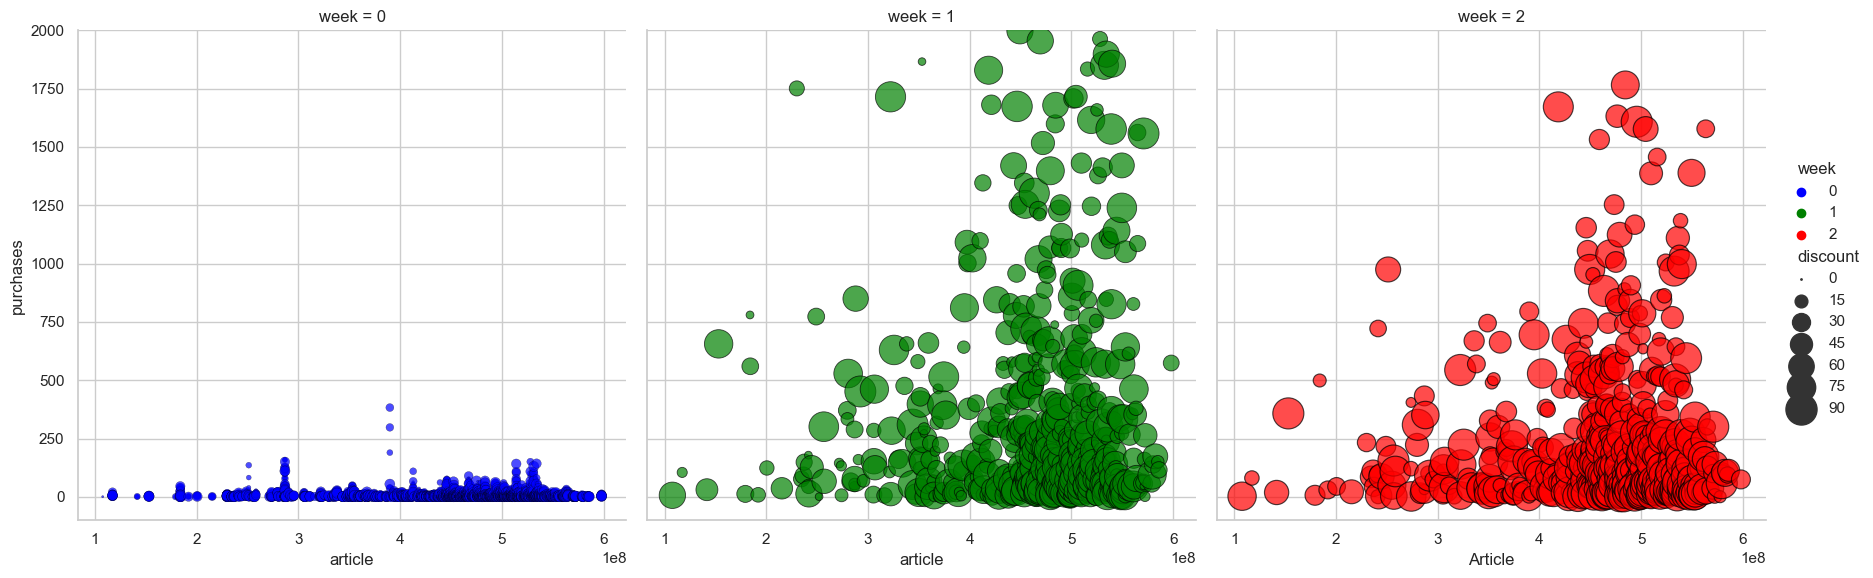

In [19]:
# Convert the 'week' column to a categorical variable with the desired order
grouped_week_article['week'] = pd.Categorical(grouped_week_article['week'], categories=['0', '1', '2'], ordered=True)

# Set seaborn "whitegrid" theme
sns.set_style("whitegrid")

# Set the figure size
plt.figure(figsize=(18, 12))  # Adjust the figure size as needed

# Set the font size
sns.set_context("notebook", rc={"font.size": 14})  # Adjust the font size as needed

# Create a dictionary mapping weeks to colors
week_colors = {'0': 'blue', '1': 'green', '2': 'red'}
# Use relplot to create separate subplots for each week
g = sns.relplot(
    data=grouped_week_article,
    x="article",
    y="purchases",
    size="discount",
    hue="week",  # Use "week" for color mapping
    palette=week_colors,
    edgecolor="black",
    facecolors='none',  # Set facecolors to 'none' for unfilled circles
    alpha=0.7,  # Set alpha to 0 for no facecolors
    sizes=(1, 500),
    col="week",  # Create separate subplots based on the "week" column
    height=6,  # Adjust the height of each subplot
    aspect=1,  # Adjust the aspect ratio of each subplot
)

# Set y-axis limits for each subplot
g.set(ylim=(-100, 2000))  # Adjust the y-axis limits as needed

# Add titles (main and on axis)
plt.xlabel("Article")
plt.ylabel("Purchases")

# Show the graph
plt.show()

In [21]:
# Group by 'week' and 'article' and sum up the purchase net_amount and group_amount
grouped_week_PRODUCT_TYPE_NAME = sales_products.groupby(['week', 'PRODUCT_TYPE_NAME', 'discount']).agg({
    'purchases': 'sum',
    'net_amount': 'sum',
    'gross_amount': 'sum'
}).reset_index()

In [60]:
grouped_week_PRODUCT_TYPE_NAME.to_csv('grouped_week_PRODUCT_TYPE_NAME.csv', index=False)

In [22]:
grouped_week_PRODUCT_TYPE_NAME

,week,PRODUCT_TYPE_NAME,discount,purchases,net_amount,gross_amount
0,0,Bag,0.09,2,99.892541,99.98
1,0,Bag,0.52,14,556.934373,559.86
2,0,Bag,1.05,6,296.801094,299.94
3,0,Bag,1.20,5,98.754225,99.95
4,0,Bag,1.22,8,237.003540,239.92
...,...,...,...,...,...,...
10657,2,Vase,29.38,56,592.812528,839.44
10658,2,Vase,64.33,26,74.100858,207.74
10659,2,Vase,90.00,210,62.790000,627.90
10660,2,Wedge,18.97,17,413.115249,509.83


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\NoteBook\AppData\Local\Temp\ipykernel_25968\4204891954.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')


<Figure size 2000x2000 with 0 Axes>

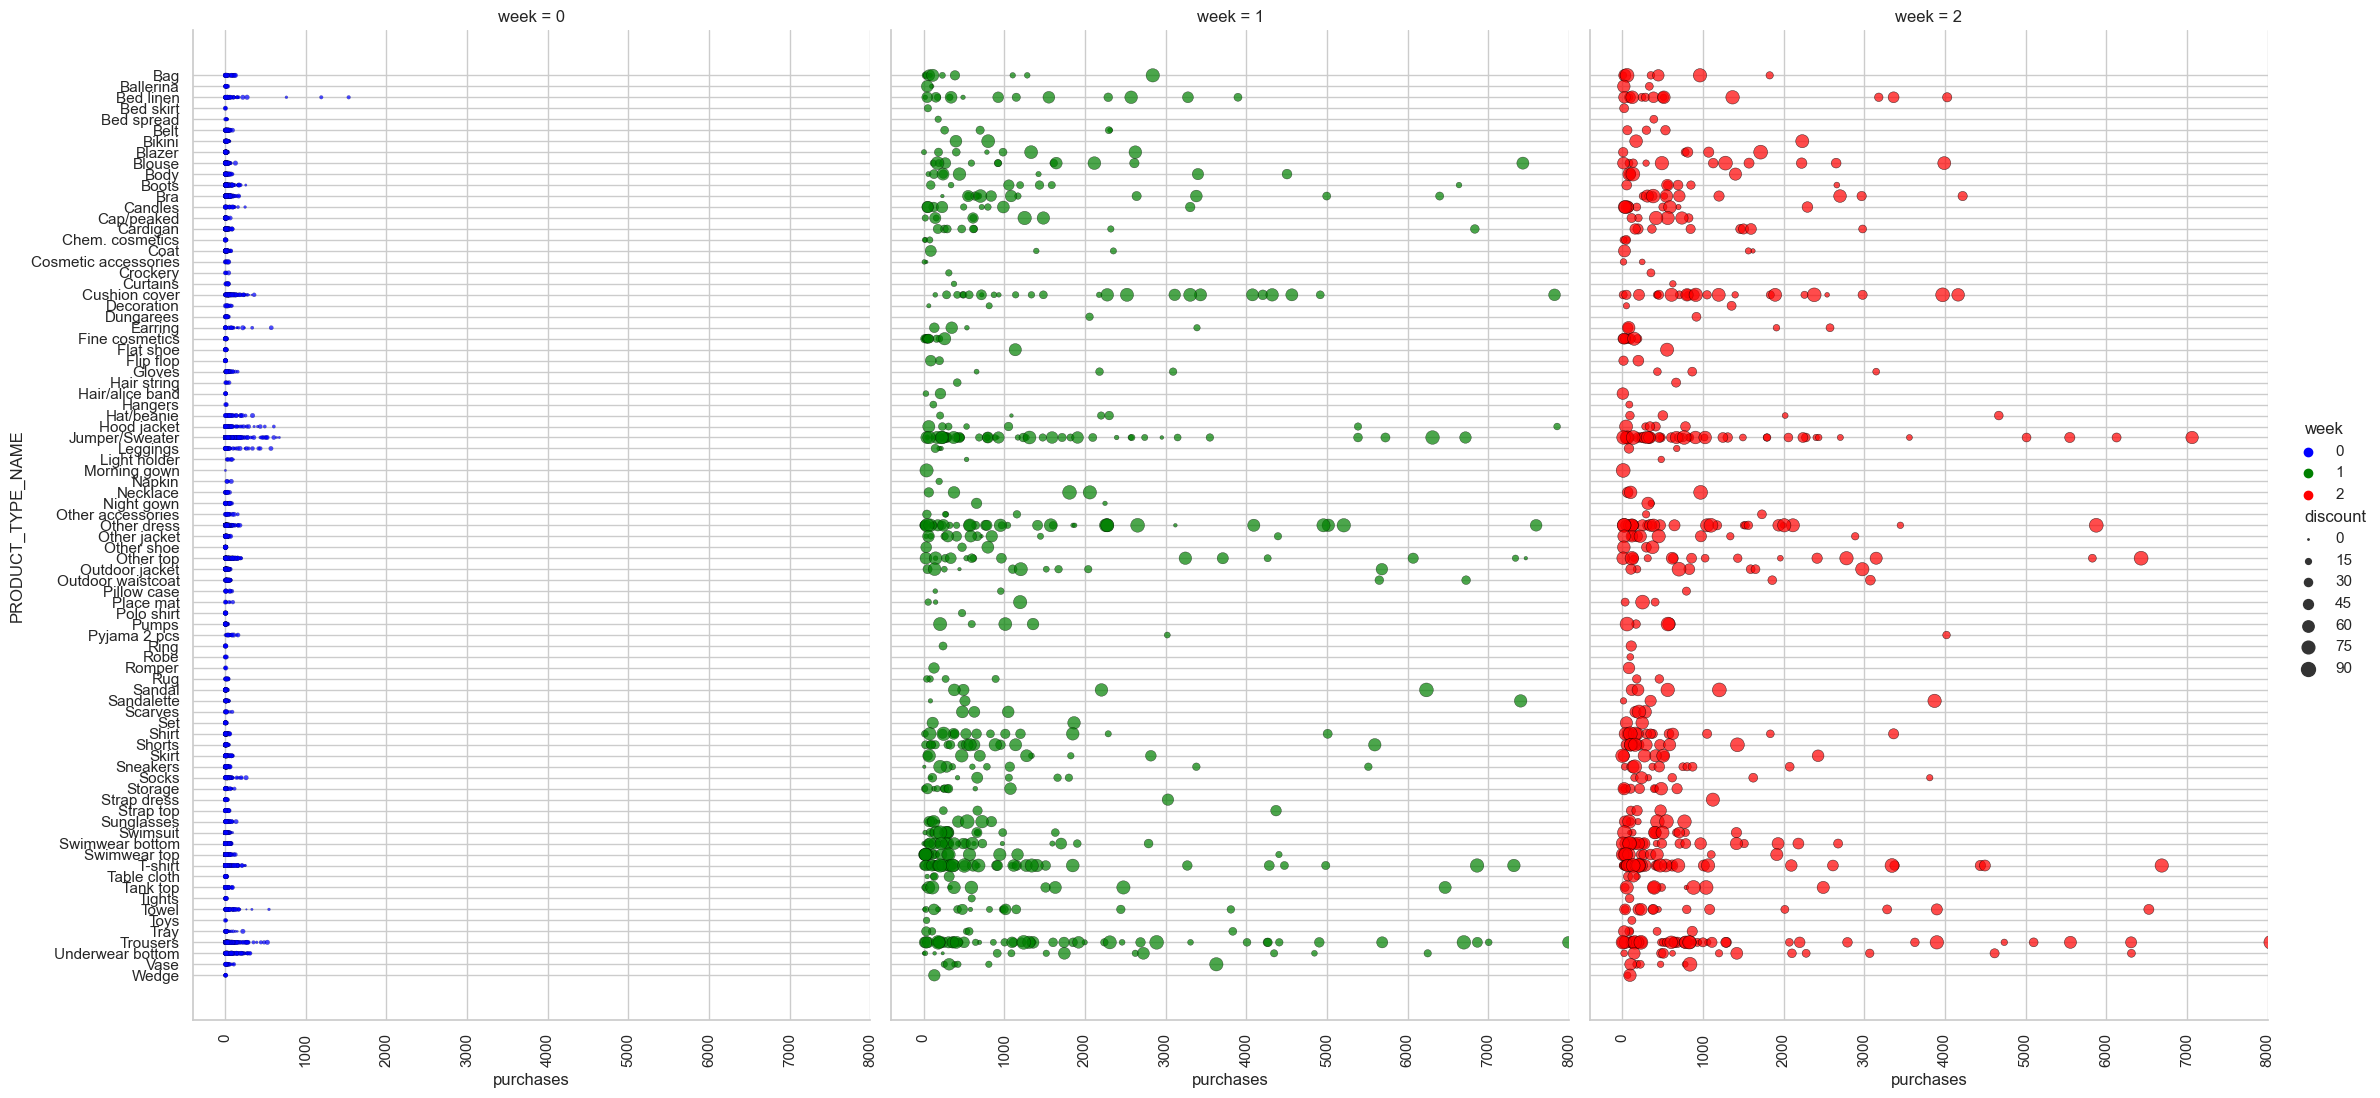

In [24]:
# Convert the 'week' column to a categorical variable with the desired order
grouped_week_PRODUCT_TYPE_NAME['week'] = pd.Categorical(grouped_week_PRODUCT_TYPE_NAME['week'], categories=['0', '1', '2'], ordered=True)

# Set seaborn "whitegrid" theme
sns.set_style("whitegrid")

# Set the figure size
plt.figure(figsize=(20, 20))  # Adjust the figure size as needed

# Set the font size
sns.set_context("notebook", rc={"font.size": 14})  # Adjust the font size as needed

# Create a dictionary mapping weeks to colors
week_colors = {'0': 'blue', '1': 'green', '2': 'red'}
# Use relplot to create separate subplots for each week
g = sns.relplot(
    data=grouped_week_PRODUCT_TYPE_NAME,
    x="purchases",
    y="PRODUCT_TYPE_NAME",
    size="discount",
    hue="week",  # Use "week" for color mapping
    palette=week_colors,
    edgecolor="black",
    facecolors='none',  # Set facecolors to 'none' for unfilled circles
    alpha=0.7,  # Set alpha to 0 for no facecolors
    sizes=(1, 100),
    col="week",  # Create separate subplots based on the "week" column
    height=11,  # Adjust the height of each subplot
    aspect=0.7,  # Adjust the aspect ratio of each subplot
)

# Rotate x-axis tick labels vertically
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
    
# Set y-axis limits for each subplot
g.set(xlim=(-100, 2000))  # Adjust the y-axis limits as needed
# Add titles (main and on axis)
plt.xlabel("purchases")
plt.ylabel("purchases")

# Show the graph
plt.show()

In [26]:
# Group by 'week' and 'article' and sum up the purchase net_amount and group_amount without considering the discount
grouped_week_PRODUCT_TYPE_NAME_without_discount = sales_products.groupby(['week', 'PRODUCT_TYPE_NAME']).agg({
    'purchases': 'sum',
    'net_amount': 'sum',
    'gross_amount': 'sum'
}).reset_index()

In [27]:
grouped_week_PRODUCT_TYPE_NAME_without_discount
#dfi.export(grouped_week_PRODUCT_TYPE_NAME_without_discount.loc[[0,1,2,3,246,247,248],:],"mytable-1.png")

,week,PRODUCT_TYPE_NAME,purchases,net_amount,gross_amount
0,0,Bag,432,12640.679154,13414.680000
1,0,Ballerina,83,3134.172772,3289.170000
2,0,Bed linen,1749,39703.552152,41812.510000
3,0,Bed skirt,5,236.420530,249.950000
4,0,Bed spread,23,880.963559,919.770000
...,...,...,...,...,...
244,2,Tray,378,4408.295906,7446.220000
245,2,Trousers,19576,234020.809706,438349.000193
246,2,Underwear bottom,5698,36937.819979,55958.020000
247,2,Vase,651,3576.757258,5235.490000


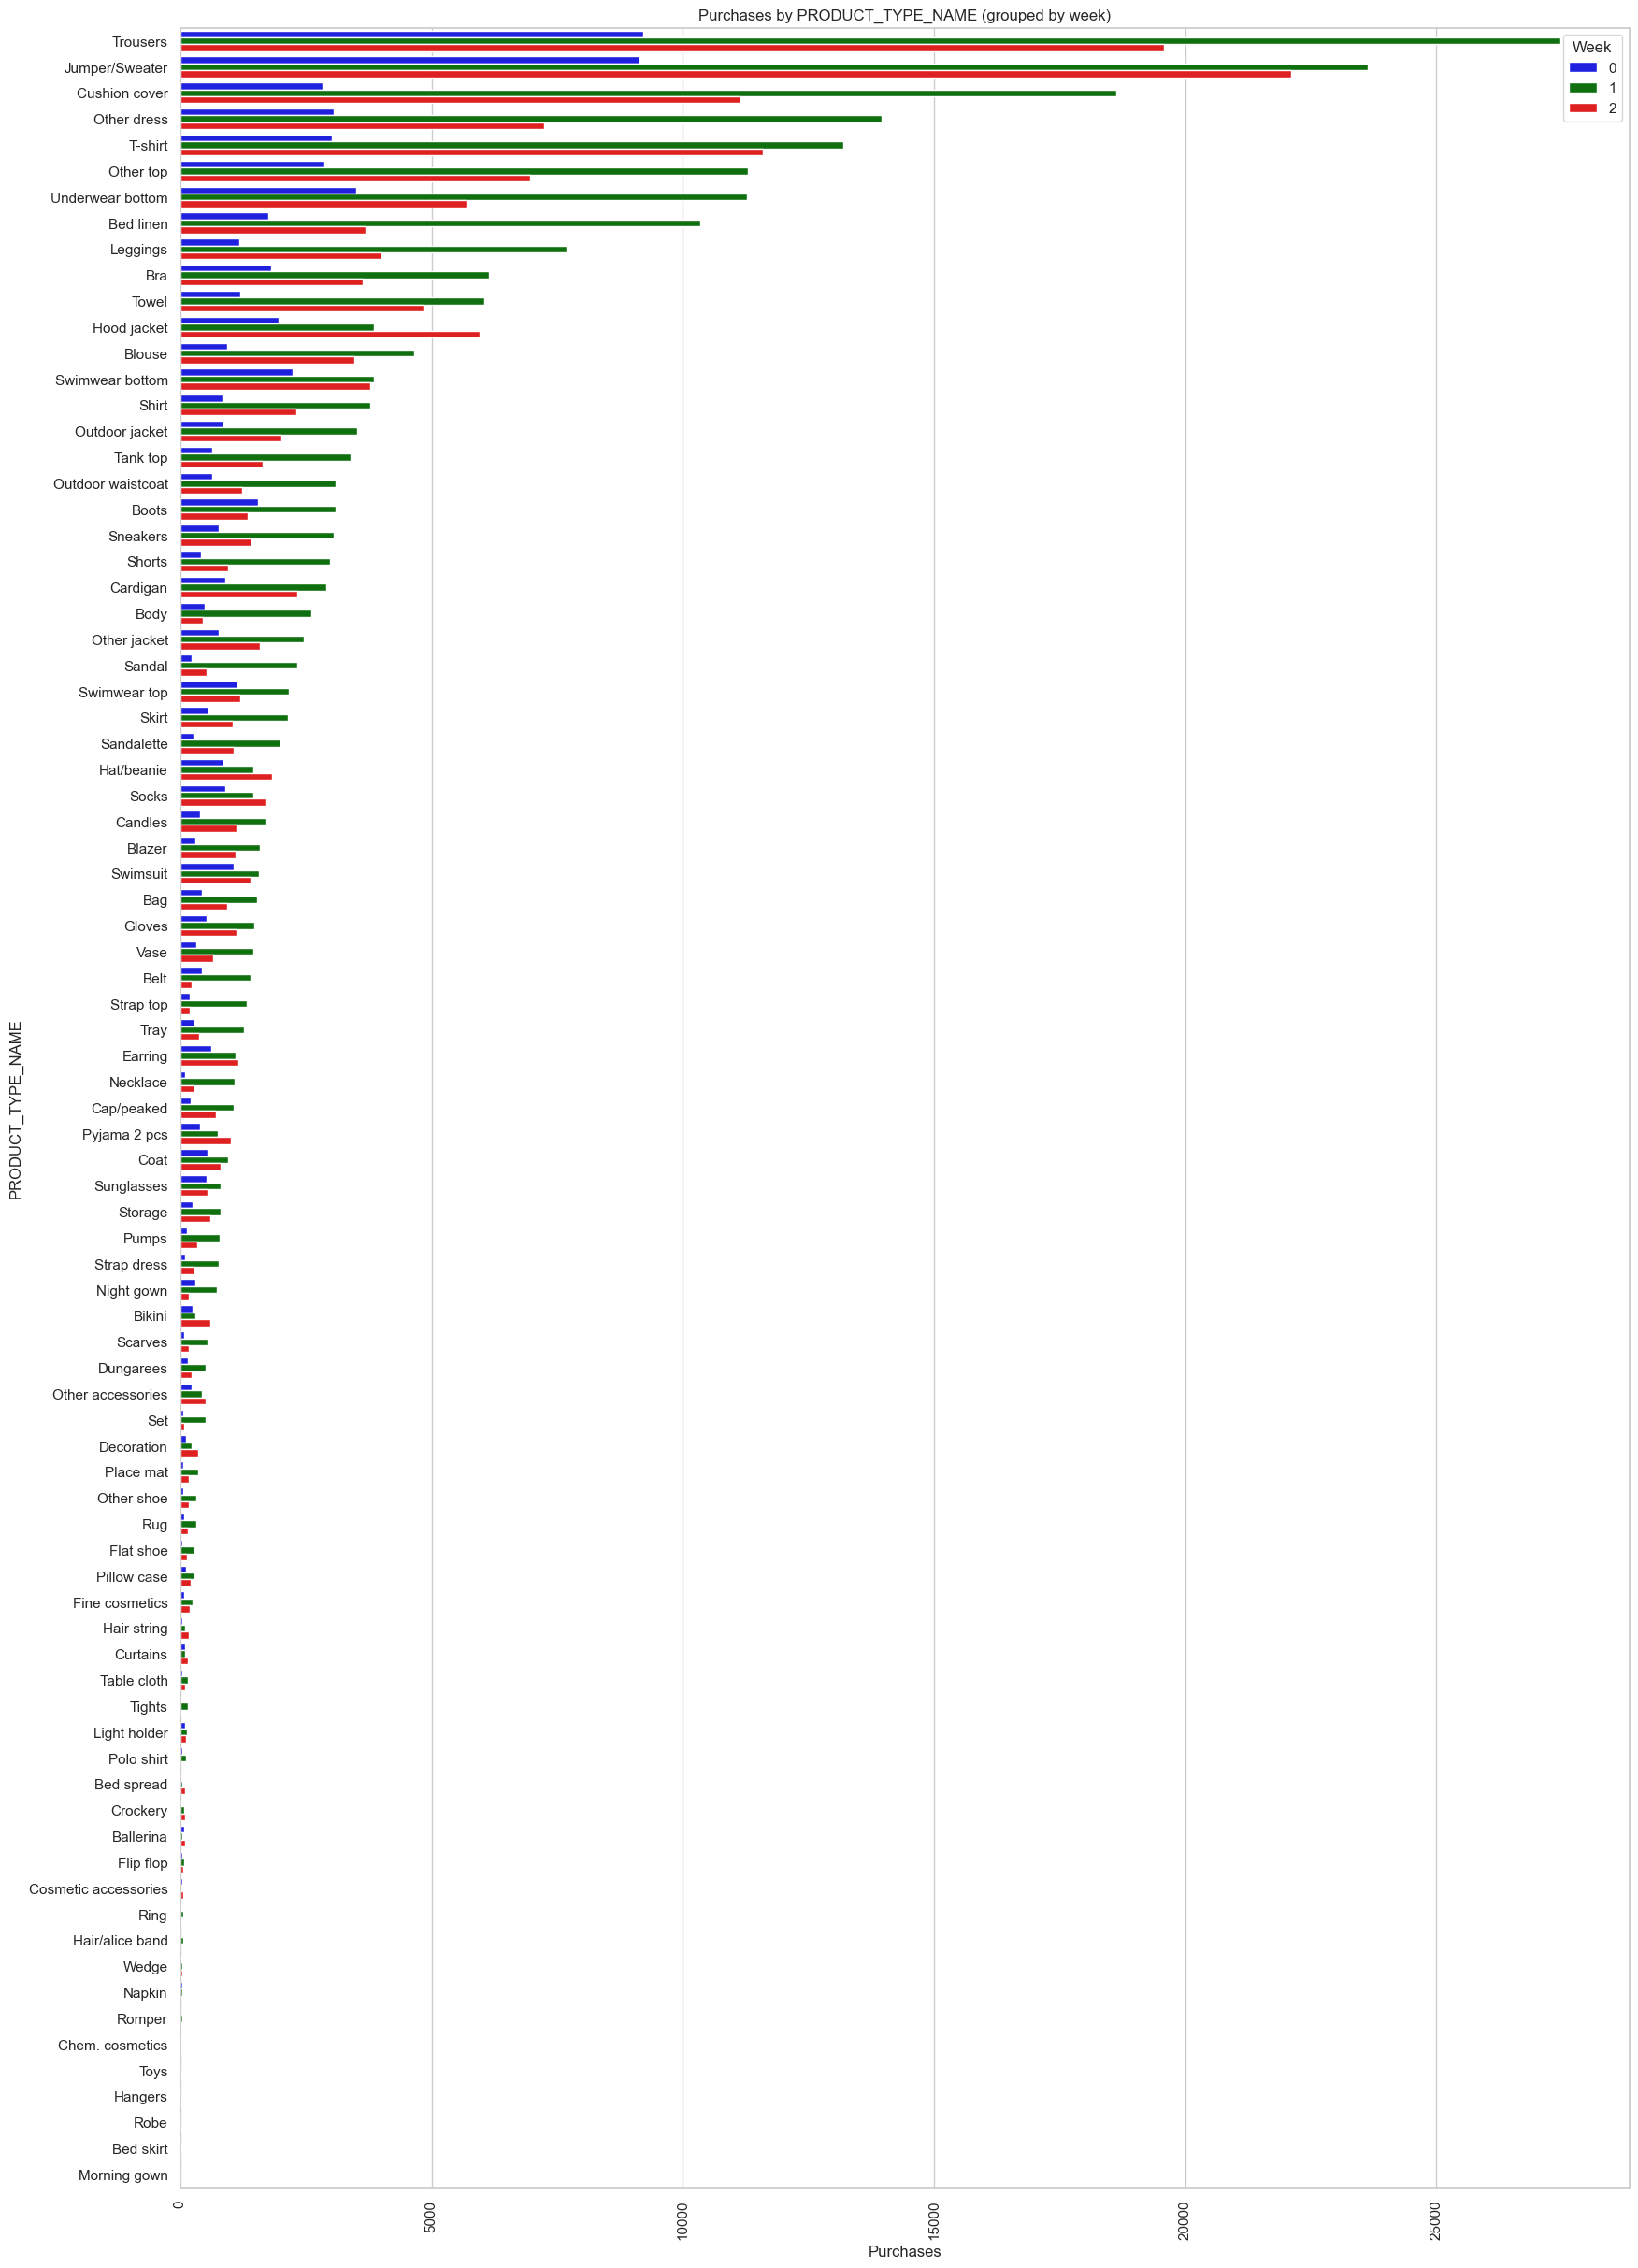

In [28]:
# Set seaborn "whitegrid" theme
sns.set_style("whitegrid")

# Set the figure size
plt.figure(figsize=(20, 30))

# Set the font size
sns.set_context("notebook", rc={"font.size": 14})

# Order PRODUCT_TYPE_NAME by maximum purchases
order_by_max_purchases = grouped_week_PRODUCT_TYPE_NAME_without_discount.groupby('PRODUCT_TYPE_NAME')['purchases'].max().sort_values(ascending=False).index

# Create a dictionary mapping weeks to colors
week_colors = {'0': 'blue', '1': 'green', '2': 'red'}
# Create a bar plot
sns.barplot(
    data=grouped_week_PRODUCT_TYPE_NAME_without_discount,
    y="PRODUCT_TYPE_NAME",
    x="purchases",
    hue="week",
    order=order_by_max_purchases,  # Order by maximum purchases
    palette=week_colors
)

# Rotate x-axis tick labels vertically for better readability
plt.xticks(rotation=90, ha='center')

# Add titles (main and on axis)
plt.xlabel("Purchases")
plt.ylabel("PRODUCT_TYPE_NAME")
plt.title("Purchases by PRODUCT_TYPE_NAME (grouped by week)")

# Show the legend
plt.legend(title="Week", loc="upper right")

# Show the plot
plt.savefig('plot.png', dpi=300, bbox_inches='tight')
plt.show()

### 2) Is it possible to predict the uplift for the first week of markdowns with the information you have? What would be the key variables? (please do not take week 2 into account in this question)

In [29]:
sales_products

,date,variant,purchases,net_amount,gross_amount,week,digit_count_variant,variant_FIRST_NINE_DIGITS,variant_size,discount,PRODUCT_CODE,PRODUCT_TYPE_NAME,DEPARTMENT_ID,DEPARTMENT_NAME,INDEX_GROUP_NAME,SECTION_NAME,article,article_FIRST_OF_DIGITS,article_CODE_REST_OF_DIGITS,digit_count_article
0,2017-10-02,494340001004,1,19.282061,19.99,0,12,494340001,4,3.54,494340,Jumper/Sweater,176,Basics,Menswear,Men Underwear,494340001,494340,1,9
1,2017-10-02,494340001006,2,39.211829,39.98,0,12,494340001,6,1.92,494340,Jumper/Sweater,176,Basics,Menswear,Men Underwear,494340001,494340,1,9
2,2017-10-02,494340001005,1,19.283717,19.99,0,12,494340001,5,3.53,494340,Jumper/Sweater,176,Basics,Menswear,Men Underwear,494340001,494340,1,9
3,2017-10-02,494340001003,1,18.531471,19.99,0,12,494340001,3,7.30,494340,Jumper/Sweater,176,Basics,Menswear,Men Underwear,494340001,494340,1,9
4,2017-10-03,494340001003,1,19.867418,19.99,0,12,494340001,3,0.61,494340,Jumper/Sweater,176,Basics,Menswear,Men Underwear,494340001,494340,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46689,2017-10-19,537116002092,0,0.000000,0.00,2,12,537116002,92,NaN,537116,Jumper/Sweater,198,Jersey Fancy Boy,Baby/Children,Baby Boy / Basics,537116002,537116,2,9
46690,2017-10-20,537116002080,0,0.000000,0.00,2,12,537116002,80,NaN,537116,Jumper/Sweater,198,Jersey Fancy Boy,Baby/Children,Baby Boy / Basics,537116002,537116,2,9
46691,2017-10-21,537116002086,0,0.000000,0.00,2,12,537116002,86,NaN,537116,Jumper/Sweater,198,Jersey Fancy Boy,Baby/Children,Baby Boy / Basics,537116002,537116,2,9
46692,2017-10-22,537116002086,0,0.000000,0.00,2,12,537116002,86,NaN,537116,Jumper/Sweater,198,Jersey Fancy Boy,Baby/Children,Baby Boy / Basics,537116002,537116,2,9


In [30]:
sales_products.columns

Index(['date', 'variant', 'purchases', 'net_amount', 'gross_amount', 'week',
       'digit_count_variant', 'variant_FIRST_NINE_DIGITS', 'variant_size',
       'discount', 'PRODUCT_CODE', 'PRODUCT_TYPE_NAME', 'DEPARTMENT_ID',
       'DEPARTMENT_NAME', 'INDEX_GROUP_NAME', 'SECTION_NAME', 'article',
       'article_FIRST_OF_DIGITS', 'article_CODE_REST_OF_DIGITS',
       'digit_count_article'],
      dtype='object')

In [35]:
sales_products_grouped = sales_products.groupby(['week', 'article', 'variant', 'variant_size', 'PRODUCT_CODE', 'PRODUCT_TYPE_NAME', 'DEPARTMENT_ID','INDEX_GROUP_NAME','SECTION_NAME']).agg({
    'purchases': 'sum',
    'net_amount': 'sum',
    'gross_amount': 'sum',
    'discount': 'mean'
}).reset_index()

sales_products_grouped_w0_w2 = sales_products_grouped[sales_products_grouped['week'] != '2']

sales_products_grouped_w0 = sales_products_grouped[sales_products_grouped['week'] == '0']

sales_products_grouped_w1 = sales_products_grouped[sales_products_grouped['week'] == '1']

In [38]:
# Check the number of unique values
unique_product_variant_count_w1 = sales_products_grouped_w1['variant'].nunique()

# Get the unique values
unique_product_variant_w1 = sales_products_grouped_w1['variant'].unique()


print("Number of unique variant in week 1:", unique_product_variant_count_w1)

Number of unique variant in week 1: 3179


In [39]:
sales_products_grouped_w1 = sales_products_grouped_w1.copy()

# Set NaN values initially
sales_products_grouped_w1['purchases_uplift'] = np.NaN
sales_products_grouped_w1['net_amount_uplift_norm'] = np.NaN
sales_products_grouped_w1['gross_amount_uplift_norm'] = np.NaN

sales_products_grouped_w1['purchases_w0'] = np.NaN
sales_products_grouped_w1['net_amount_w0'] = np.NaN
sales_products_grouped_w1['gross_amount_w0'] = np.NaN
sales_products_grouped_w1['discount_w0'] = np.NaN


for index_w1, row_w1 in sales_products_grouped_w1.iterrows():
    w1_variant = row_w1['variant']
    row_w0 = sales_products_grouped_w0[sales_products_grouped_w0['variant'] == w1_variant]

    # check if find the record in w0 dataframe
    if row_w0.shape[0] != 1:
        continue

    sales_products_grouped_w1.loc[sales_products_grouped_w1['variant'] == w1_variant, 'purchases_w0'] = row_w0['purchases'].values[0]
    sales_products_grouped_w1.loc[sales_products_grouped_w1['variant'] == w1_variant,'net_amount_w0'] = row_w0['net_amount'].values[0]
    sales_products_grouped_w1.loc[sales_products_grouped_w1['variant'] == w1_variant,'gross_amount_w0'] = row_w0['gross_amount'].values[0]
    sales_products_grouped_w1.loc[sales_products_grouped_w1['variant'] == w1_variant,'discount_w0'] = row_w0['discount'].values[0]

    # Use loc for both assignment and filtering
    sales_products_grouped_w1.loc[sales_products_grouped_w1['variant'] == w1_variant, 'purchases_uplift'] = (sales_products_grouped_w1.loc[sales_products_grouped_w1['variant'] == w1_variant, 'purchases'].values[0] /row_w0['purchases'].values[0] )
    sales_products_grouped_w1.loc[sales_products_grouped_w1['variant'] == w1_variant, 'net_amount_uplift_norm'] = (
        sales_products_grouped_w1.loc[sales_products_grouped_w1['variant'] == w1_variant, 'net_amount'].values[0] /
        sales_products_grouped_w1.loc[sales_products_grouped_w1['variant'] == w1_variant, 'purchases'].values[0] )/ (row_w0['net_amount'].values[0] / row_w0['purchases'].values[0])
    sales_products_grouped_w1.loc[sales_products_grouped_w1['variant'] == w1_variant, 'gross_amount_uplift_norm'] = (
        sales_products_grouped_w1.loc[sales_products_grouped_w1['variant'] == w1_variant, 'gross_amount'].values[0] /
        sales_products_grouped_w1.loc[sales_products_grouped_w1['variant'] == w1_variant, 'purchases'].values[0]) /(row_w0['gross_amount'].values[0] / row_w0['purchases'].values[0])

C:\Users\NoteBook\AppData\Local\Temp\ipykernel_25968\2768732150.py:30: RuntimeWarning: invalid value encountered in scalar divide
  sales_products_grouped_w1.loc[sales_products_grouped_w1['variant'] == w1_variant, 'net_amount'].values[0] /
C:\Users\NoteBook\AppData\Local\Temp\ipykernel_25968\2768732150.py:33: RuntimeWarning: invalid value encountered in scalar divide
  sales_products_grouped_w1.loc[sales_products_grouped_w1['variant'] == w1_variant, 'gross_amount'].values[0] /


In [40]:
# Drop rows where 'net_amount_w0', 'gross_amount_w0', 'discount_w0' have NaN values
sales_products_grouped_w1.dropna(subset=['net_amount_w0', 'gross_amount_w0', 'discount_w0'], inplace=True)

sales_products_grouped_w1.columns

Index(['week', 'article', 'variant', 'variant_size', 'PRODUCT_CODE',
       'PRODUCT_TYPE_NAME', 'DEPARTMENT_ID', 'INDEX_GROUP_NAME',
       'SECTION_NAME', 'purchases', 'net_amount', 'gross_amount', 'discount',
       'purchases_uplift', 'net_amount_uplift_norm',
       'gross_amount_uplift_norm', 'purchases_w0', 'net_amount_w0',
       'gross_amount_w0', 'discount_w0'],
      dtype='object')

In [44]:
# Data Preparation for Machine Learning:
X = sales_products_grouped_w1[['article', 'variant', 'variant_size', 'PRODUCT_CODE',
       'PRODUCT_TYPE_NAME', 'DEPARTMENT_ID', 'INDEX_GROUP_NAME',
       'SECTION_NAME', 'purchases', 'discount', 'purchases_w0', 'net_amount_w0', 'gross_amount_w0', 'discount_w0']]

Y = sales_products_grouped_w1['purchases_uplift']

In [46]:
# Assuming you have a DataFrame 'df' containing X and Y
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define categorical and numerical features
categorical_features = ['article', 'variant', 'variant_size', 'PRODUCT_CODE', 'PRODUCT_TYPE_NAME', 'DEPARTMENT_ID', 'INDEX_GROUP_NAME', 'SECTION_NAME']
numerical_features = ['purchases', 'discount', 'purchases_w0', 'net_amount_w0', 'gross_amount_w0', 'discount_w0']

# Create transformers for categorical and numerical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])

# Create a pipeline with the preprocessor and RandomForestRegressor
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor(random_state=42))])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model (for regression)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 9.990140897876183


In [52]:
# Make predictions on the test set (already done)
y_pred = pipeline.predict(X_test)

# Calculate the test MSE
mse_test = mean_squared_error(y_test, y_pred)
print(f'Test Mean Squared Error: {mse_test}')

# Make predictions on the training set
y_train_pred = pipeline.predict(X_train)

# Calculate the training MSE
mse_train = mean_squared_error(y_train, y_train_pred)
print(f'Training Mean Squared Error: {mse_train}')


Test Mean Squared Error: 9.990140897876183
Training Mean Squared Error: 7.008676297835714


In [56]:
from sklearn.metrics import r2_score

# Assuming y_test is your actual values and y_pred is your predicted values
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

R-squared: 0.8185786012224243


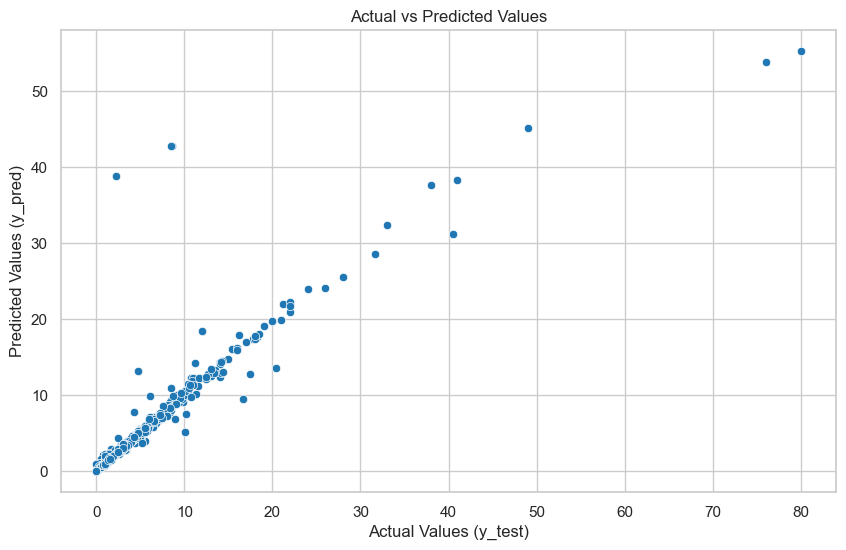

In [47]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.savefig('plot-1.png', dpi=300, bbox_inches='tight')
plt.show()

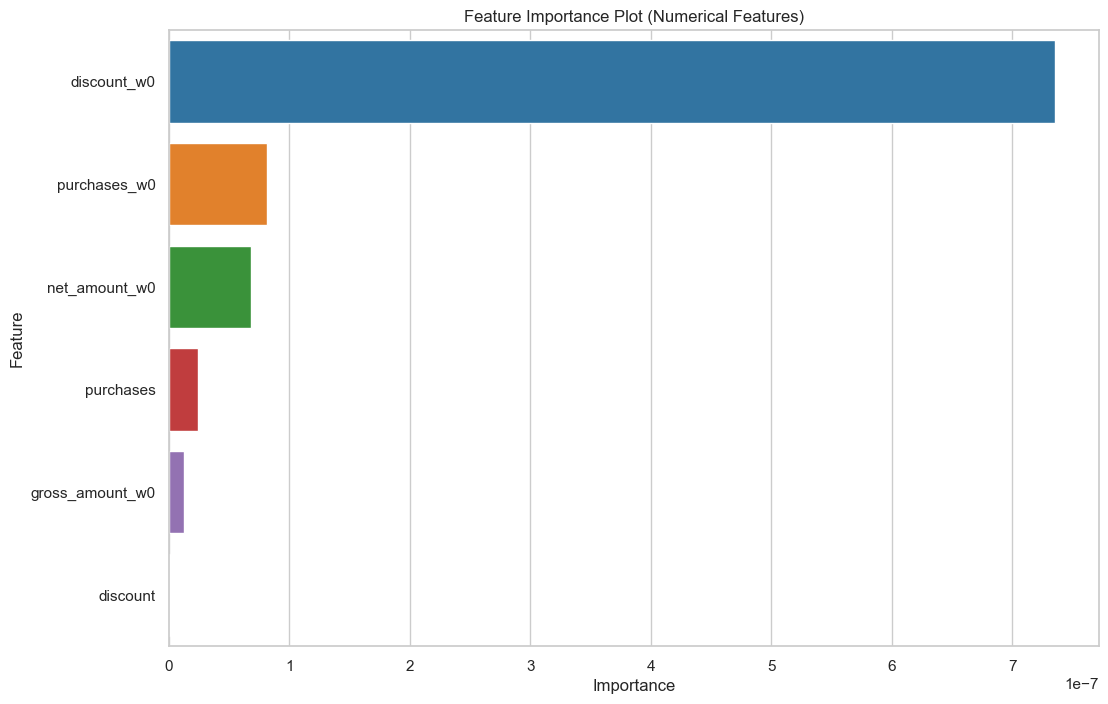

In [54]:
# Assuming the pipeline is already fitted
# Extract the RandomForestRegressor from the pipeline
regressor = pipeline.named_steps['regressor']

# Extract numerical feature names
numerical_features = ['purchases', 'discount', 'purchases_w0', 'net_amount_w0', 'gross_amount_w0', 'discount_w0']

# Ensure the lengths match by taking the top features
top_features = len(numerical_features)
importance_df = pd.DataFrame({'Feature': numerical_features[:top_features], 'Importance': regressor.feature_importances_[:top_features]})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot for feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance Plot (Numerical Features)')
plt.show()

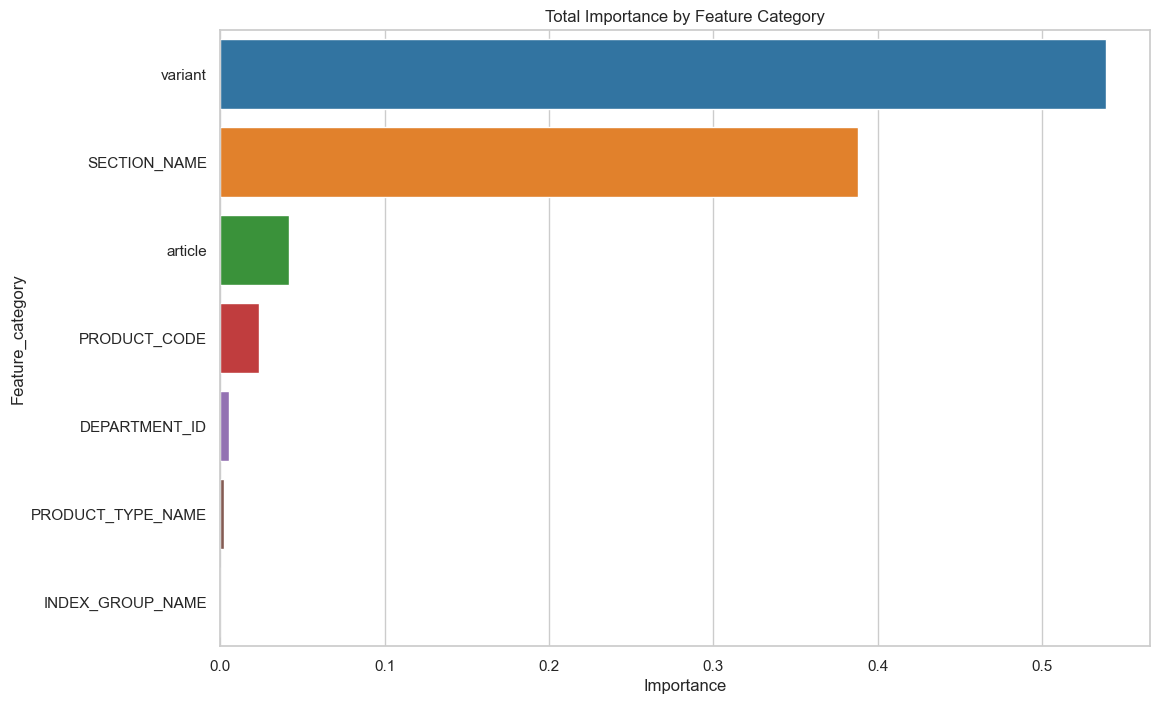

In [51]:
# Extract the RandomForestRegressor from the pipeline
regressor = pipeline.named_steps['regressor']

# Define the original categorical features
categorical_features = ['article', 'variant', 'variant_size', 'PRODUCT_CODE', 'PRODUCT_TYPE_NAME', 'DEPARTMENT_ID', 'INDEX_GROUP_NAME', 'SECTION_NAME']

# Extract one-hot encoded feature names using get_feature_names_out
categorical_encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
encoded_feature_names = list(categorical_encoder.get_feature_names_out(categorical_features))

# Extract categorical feature importances from the end of the feature_importances_ array
categorical_importances = regressor.feature_importances_[-len(encoded_feature_names):]

# Create a DataFrame for categorical feature importances
importance_df_cat = pd.DataFrame({'Feature': encoded_feature_names, 'Importance': categorical_importances})

# Sort the DataFrame by importance in descending order
importance_df_cat = importance_df_cat.sort_values(by='Importance', ascending=False)

# Categorize features by their original categorical columns
importance_df_cat['Feature_category'] = importance_df_cat['Feature'].apply(lambda x: 'article' if 'article' in x else 
                                                'variant' if 'variant' in x else
                                                'variant_size' if 'variant_size' in x else
                                                'PRODUCT_CODE' if 'PRODUCT_CODE' in x else
                                                'PRODUCT_TYPE_NAME' if 'PRODUCT_TYPE_NAME' in x else
                                                'DEPARTMENT_ID' if 'DEPARTMENT_ID' in x else
                                                'INDEX_GROUP_NAME' if 'INDEX_GROUP_NAME' in x else
                                                'SECTION_NAME' if 'SECTION_NAME' in x else
                                                'Other')

# Group by feature category and sum their importance
grouped_df = importance_df_cat.groupby('Feature_category')['Importance'].sum().reset_index()

# Sort the grouped DataFrame by Importance
sorted_df = grouped_df.sort_values(by='Importance', ascending=False)

# Create a bar plot of feature importances by category
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature_category', data=sorted_df)
plt.title('Total Importance by Feature Category')
plt.show()
